In [36]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import json

from collections import defaultdict
from tqdm import tqdm

from pathlib import Path
from typing import List, Dict, Tuple, Union, Callable, Optional, Any

In [82]:
surrogate_analysis_folder = "../analysis/surrogates"
raw_mo_analysis_folder = "../analysis/raw_mo"
seed_list = [17, 21, 42, 81, 123]

In [87]:
def gather_surrogate_results(surrogate_analysis_folder: str, seed_list: List[int]) -> Dict[int, Dict[int, Dict[int, Dict[str, Any]]]]:
    """
    Gathers the results of the surrogate analysis.
    """
    size_seed_results = defaultdict(lambda: defaultdict(dict))
    for pareto_steps in os.listdir(surrogate_analysis_folder):
        pareto_steps_folder = os.path.join(surrogate_analysis_folder, pareto_steps)
        for data_size in os.listdir(pareto_steps_folder):
            for seed in seed_list: 
                seed_folder = os.path.join(pareto_steps_folder, data_size, str(seed))
                with open(os.path.join(seed_folder, "pareto_metrics.json"), "r") as f:
                    results = json.load(f)
                size_seed_results[int(pareto_steps)][int(data_size)][seed] = results
                
    return size_seed_results
    

In [95]:
def gather_raw_mo_results(raw_mo_analysis_folder: str, seed_list: List[int]) -> Dict[int, Dict[int, Dict[int, Dict[str, Any]]]]:
    """
    Gathers the results of the raw_mo analysis.
    """
    size_seed_results = defaultdict(lambda: defaultdict(dict))
    for pareto_steps in os.listdir(raw_mo_analysis_folder):
        pareto_steps_folder = os.path.join(raw_mo_analysis_folder, pareto_steps)
        for seed in seed_list: 
            seed_folder = os.path.join(pareto_steps_folder, str(seed))
            with open(os.path.join(seed_folder, "pareto_metrics.json"), "r") as f:
                results = json.load(f)
            size_seed_results[int(pareto_steps)][seed] = results
                
    return size_seed_results
    

In [125]:
def get_avg_results(size_seed_results: Dict, metric: str, pareto_steps: int) -> Dict[int, Dict[int, Dict[int, Dict[str, Any]]]]:
    """
    Returns the average results for a given metric.
    """

    avg_results = {}
    for data_size in size_seed_results[pareto_steps].keys():
        avg_results[data_size] = np.mean([size_seed_results[pareto_steps][data_size][seed][metric] for seed in seed_list])
        
    
    return avg_results


def get_avg_raw_mo_results(size_seed_results: Dict, metric: str, pareto_steps: int) -> Dict:
    """
    Returns the average results for a given metric.
    """

    avg_results = {}
    for seed in size_seed_results[pareto_steps].keys():
        avg_results[seed] = np.mean([size_seed_results[pareto_steps][seed][metric] for seed in seed_list])
        
    
    return avg_results

In [109]:
def get_total_trained_archs(size_seed_results: Dict, pareto_steps: int, seed_list: List[int]) -> Dict[int, Dict[int, Dict[int, Dict[str, Any]]]]:
    """
    Returns the total number of trained architectures for each data size.
    """
    total_trained_archs = defaultdict(lambda: defaultdict(int))

    for data_size in size_seed_results[pareto_steps].keys():
        for seed in seed_list: 
            total_trained_archs[data_size][seed] += size_seed_results[pareto_steps][data_size][seed]["trained_arch_cnt"]
            
    return total_trained_archs
    
    
def get_avg_trained_archs_per_step(total_trained_archs: Dict, step: int) -> Dict:
    
    avg_trained_archs_per_step = {}
    for data_size in total_trained_archs.keys():
        avg_trained_archs_per_step[data_size] = np.mean([total_trained_archs[data_size][seed] for seed in seed_list])
        
    avg_trained_archs_per_step = {k: v/step for k, v in avg_trained_archs_per_step.items()}         
        
    return avg_trained_archs_per_step
    

#### Results dict example: 
```
{
    'trained_arch_cnt': 3399,
    'hypervolume': 52.56181391334056,
    'avg_hypervolume': 4.778346719394596,
    'diameter': 18,
    'podist_avg': 6.363636363636363,
    'best_acc': 0.9466145634651184,
    'best_train_time': 546.0150146484375,
    'avg_acc': 0.9250528053803877,
    'avg_train_time': 1297.5351895419035,
    'std_acc': 0.030014588105400416,
    'std_train_time': 529.5832355037414
}
```

## The analysis for 20 pareto steps

In [105]:
size_seed_results_20 = gather_surrogate_results(surrogate_analysis_folder, seed_list)
total_trained_archs_20 = get_total_trained_archs(size_seed_results_20, 20, seed_list)
hypervolume_20 = get_avg_results(size_seed_results_20, "hypervolume", 20)
diameter_20 = get_avg_results(size_seed_results_20, "diameter", 20)
best_acc_20 = get_avg_results(size_seed_results_20, "best_acc", 20)
best_train_time_20 = get_avg_results(size_seed_results_20, "best_train_time", 20)

In [121]:
avg_train_per_run = {}
for data_size in total_trained_archs_20: 
    avg_train_per_run[data_size] = np.mean([total_trained_archs_20[data_size][seed] for seed in seed_list])
    
np.mean([avg_train_per_run[train_size] for train_size in avg_train_per_run])

4486.436363636364

In [118]:
trained_archs_per_step = get_avg_trained_archs_per_step(total_trained_archs_20, 20)
total_step_avg = np.mean(([val for val in trained_archs_per_step.values()]))
total_avg

224.32181818181817

### Since we have `4487` architectures trained for 20 steps for 20 stating points and we have trained the surrogate models up to 800 data size and the average step trains around 1000 architectures, we can add 4 more steps to MO.

In [131]:
raw_size_seed_results = gather_raw_mo_results(raw_mo_analysis_folder, seed_list)


In [132]:
raw_size_seed_results.keys()

dict_keys([7, 24, 22, 25, 12])

In [138]:
raw_diameter_24 = get_avg_raw_mo_results(raw_size_seed_results, "diameter", 24)
raw_hypervolume_24 = get_avg_raw_mo_results(raw_size_seed_results, "hypervolume", 24)
raw_best_acc_24 = get_avg_raw_mo_results(raw_size_seed_results, "best_acc", 24)
raw_best_train_time_24 = get_avg_raw_mo_results(raw_size_seed_results, "best_train_time", 24)

In [68]:
def plot_results(results: Dict, title: str, x_label: str, y_label: str, sizes: List[int], rotation: int = 45) -> None:
    """
    Plots the results.
    """
    selected_data = {key: results[key] for key in sizes}

    
    plt.figure(figsize=(10, 6))
    plt.plot(selected_data.keys(), selected_data.values(), marker='o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=rotation)
    
    plt.show()


### MO Plots

In [70]:
small_data_sizes = [300, 400, 500, 600, 700, 800, 900, 1000]

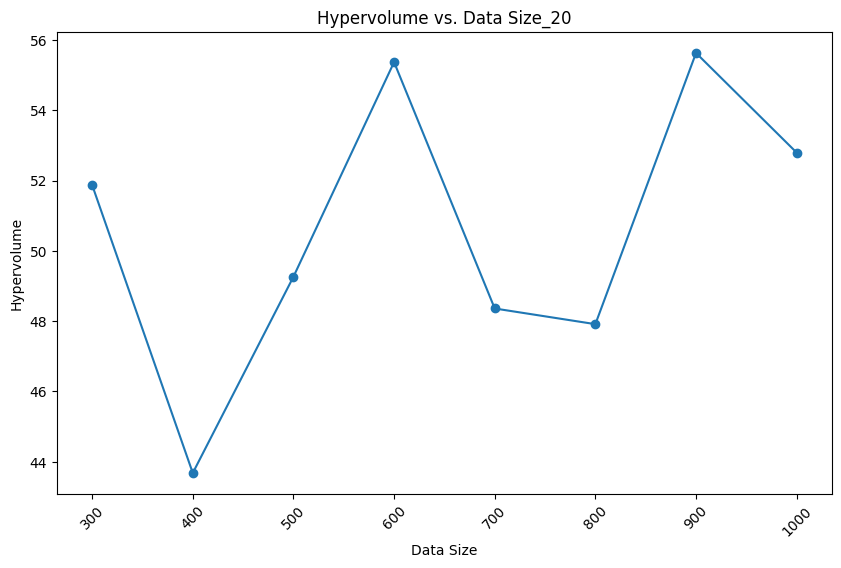

In [71]:
plot_results(hypervolume_20, "Hypervolume vs. Data Size_20", "Data Size", "Hypervolume", sizes=small_data_sizes)

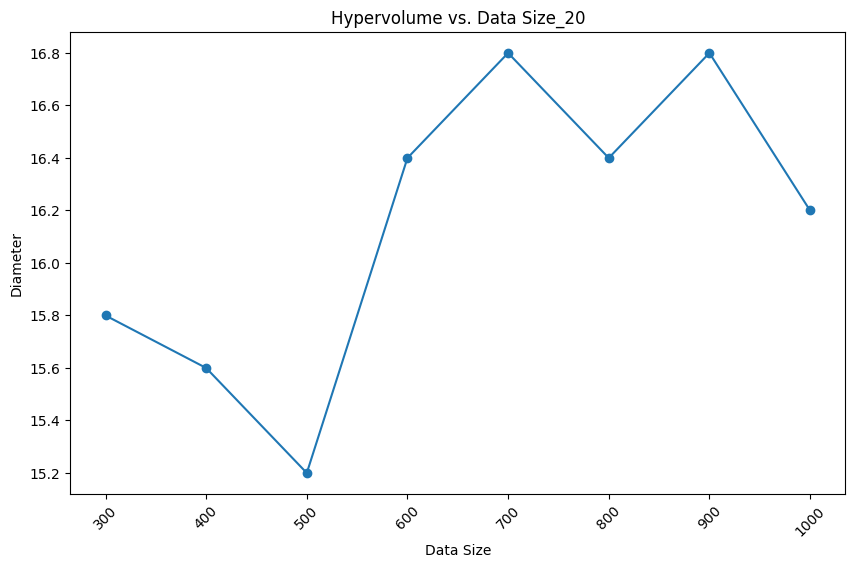

In [73]:
plot_results(diameter_20, "Diameter vs. Data Size_20", "Data Size", "Diameter", sizes=small_data_sizes)

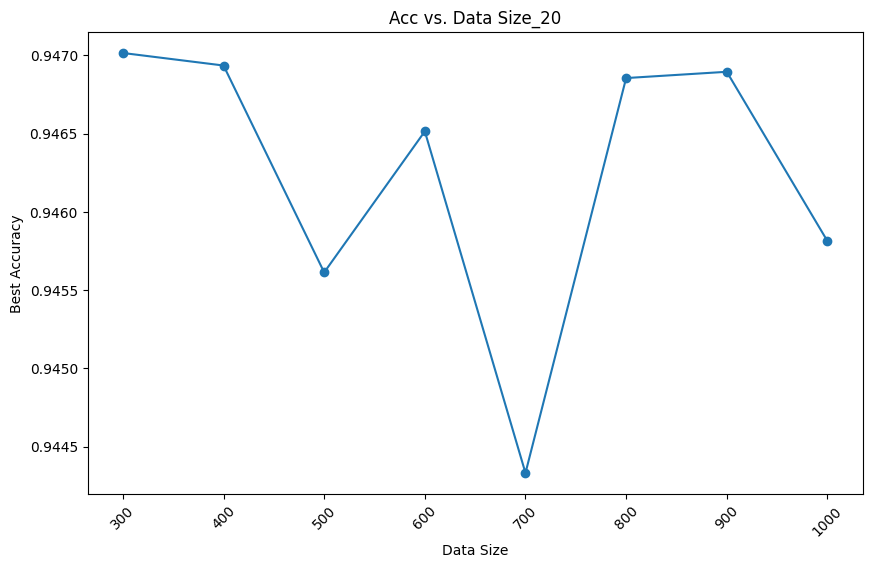

In [74]:
plot_results(best_acc_20, "Acc vs. Data Size_20", "Data Size", "Best Accuracy", sizes=small_data_sizes)

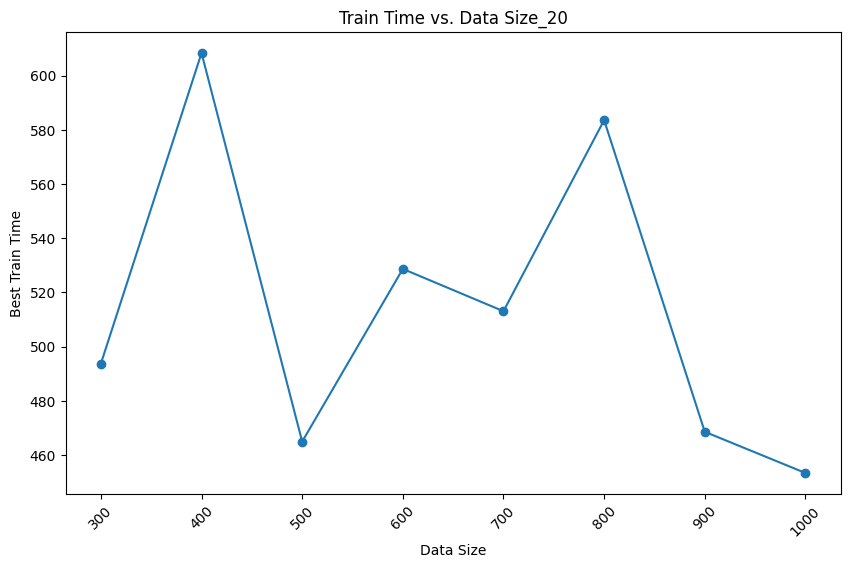

In [75]:
plot_results(best_train_time_20, "Train Time vs. Data Size_20", "Data Size", "Best Train Time", sizes=small_data_sizes)

In [76]:
big_data_sizes = [1000, 2000, 3000, 5000]

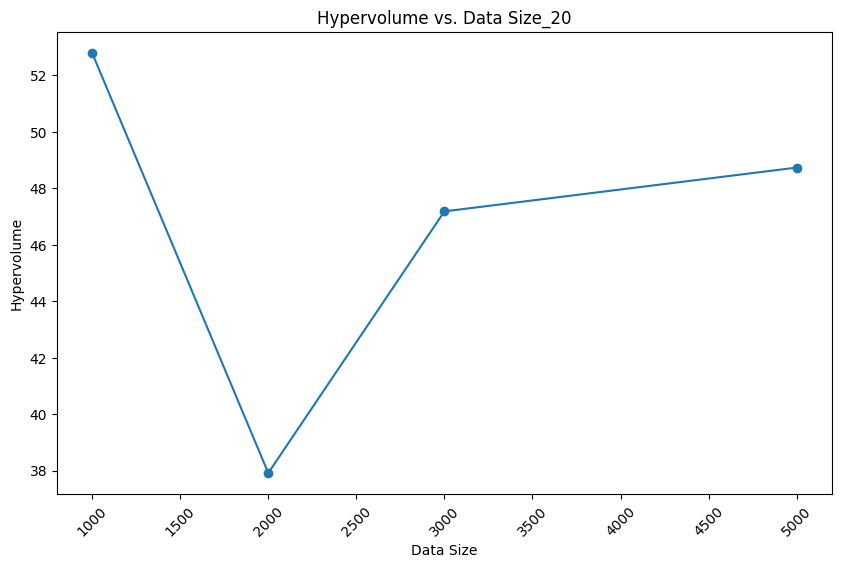

In [77]:
plot_results(hypervolume_20, "Hypervolume vs. Data Size_20", "Data Size", "Hypervolume", sizes=big_data_sizes)

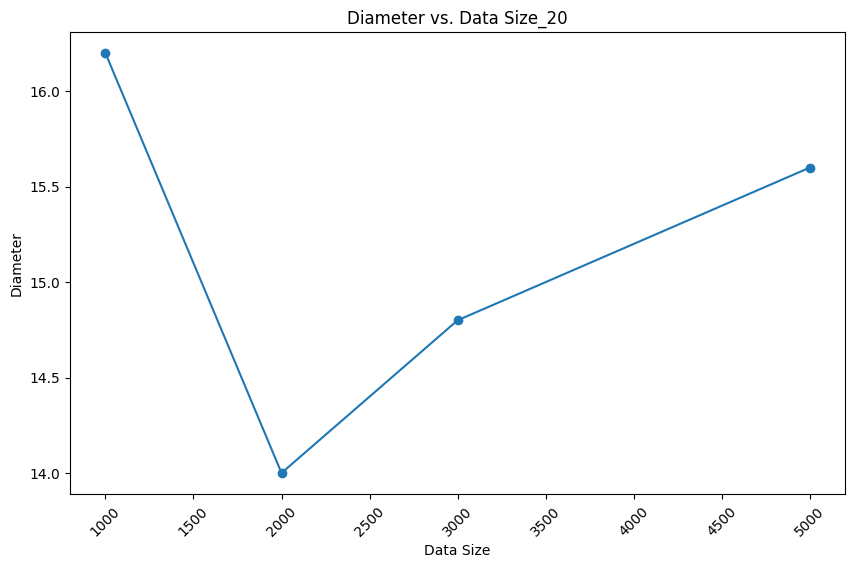

In [78]:
plot_results(diameter_20, "Diameter vs. Data Size_20", "Data Size", "Diameter", sizes=big_data_sizes)

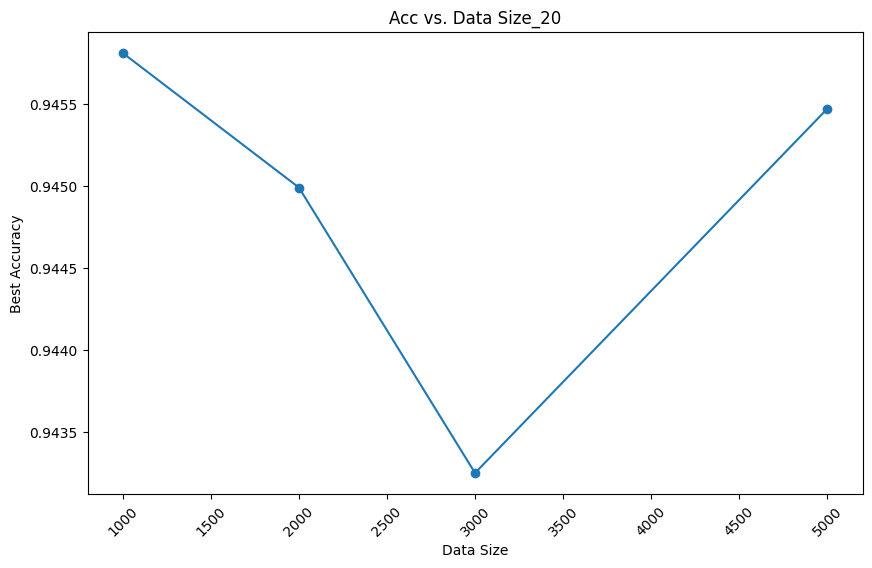

In [79]:
plot_results(best_acc_20, "Acc vs. Data Size_20", "Data Size", "Best Accuracy", sizes=big_data_sizes)

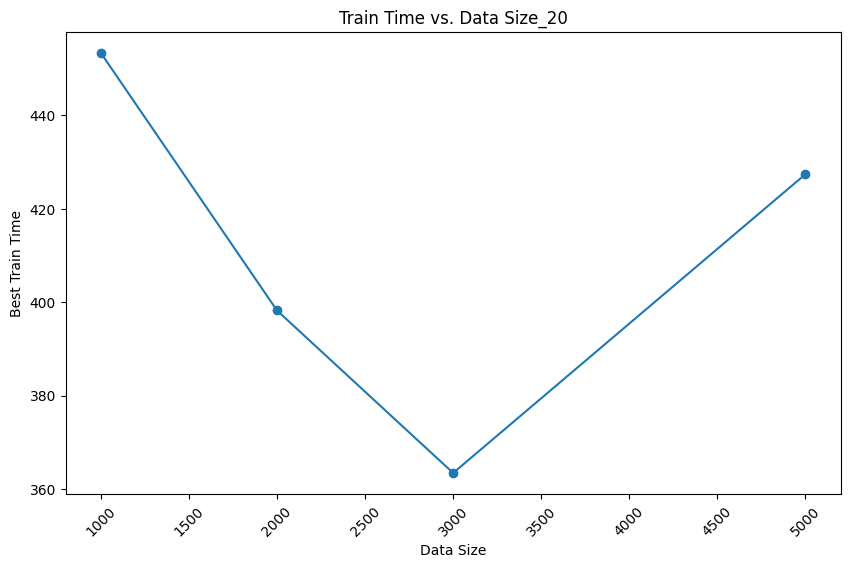

In [80]:
plot_results(best_train_time_20, "Train Time vs. Data Size_20", "Data Size", "Best Train Time", sizes=big_data_sizes)